In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import os
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xwmt.swmt import swmt
from xwmt.compute import lbin_define

In [5]:
import sys
sys.path.append('../scripts')
from preprocessing import preprocessing

In [4]:
outdir='/scratch/gpfs/jt7058/GFDL/fafmip/netcdf/'
zarrdir='/scratch/gpfs/jt7058/GFDL/fafmip/'
mod = 'CM4' # CM4, ESM4
exp = 'control' # control, antwater, stress, antwaterstress
mem = 201 # 251, 290, 332 (CM4) / 101, 151, 201 (ESM4)

In [4]:
file_path = os.path.join(zarrdir,'zarr',mod,exp,'monthly') if exp=='control' \
            else os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
print(file_path)
ds = xr.open_zarr(file_path)

/scratch/gpfs/jt7058/GFDL/fafmip/zarr/CM4/control/monthly


In [5]:
rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/'
pp = 'ocean_monthly'

if mod == 'CM4':
    subdir = 'CM4_piControl_C'
    grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
elif mod == 'ESM4':
    subdir = 'ESM4_piControl_D'
    grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
else:
    print('grid is not available for '+subdir)

In [6]:
rho2_i = xr.open_dataset(os.path.join(rootdir,subdir,'ocean_annual_rho2')\
                       +'/ocean_annual_rho2.0251-0255.vmo.nc').rho2_i.values
rho2_l = xr.open_dataset(os.path.join(rootdir,subdir,'ocean_annual_rho2')\
                       +'/ocean_annual_rho2.0251-0255.vmo.nc').rho2_l.values

In [7]:
ds = preprocessing(ds, grid, decode_times=False, verbose=False)

In [8]:
# Isolate Southern Ocean
#north = -65.8
#north = -58.0
north = -30.0

# Isolate Southern Ocean
ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)
ds_so['time_bnds'] = ds.time_bnds

In [9]:
# Initialize 2D surface WMT class
dd = swmt(ds_so)

In [10]:
#lstr = 'sigma0'
#dl,sigi,sigf = 0.02, 26.01 , 28.49
#dl,sigi,sigf = 0.05, 25.0 , 28.5

#lstr = 'sigma1'
#dl,sigi,sigf = 0.02, 31.01 , 33.49
#dl,sigi,sigf = 0.05, 30.0 , 33.5
#dl,sigi,sigf = 0.3, 31.55 , 32.15

lstr = 'sigma2'
#dl,sigi,sigf = 0.02, 35.41, 37.89
dl,sigi,sigf = 0.05, 34.0 , 38.0
#dl,sigi,sigf = 0.125, 34.0625 , 36.8125
lbins = lbin_define(sigi,sigf,dl)
#lbins = rho2_i-1000

In [11]:
if mod=='CM4':
    if exp=='control':
        yr_st,yr_ed = '0281','0380'
    else:
        yr_st,yr_ed = '0051','0070'
elif mod=='ESM4':
    if exp=='control':
        yr_st,yr_ed = '0121','0220'
    elif mem==101:
        yr_st,yr_ed = '0151','0170'
    else:
        yr_st,yr_ed = '0051','0070'

## Integrated WMT

In [12]:
G_srf = dd.G(lstr, bins=lbins)#, method='xgcm')

In [13]:
dsG = G_srf.reset_coords(drop=True).to_dataset(name='swmt')

In [12]:
var = 'swmt' # wmt, swmt
#dl_str = str(dl).replace('.','').ljust(3, '0')
dl_str = 'lores'

head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
fname = head+'_so_%sto%s_southof%sS_%s_%s_%s.nc'\
        %(str(ds_so.time.dt.year[0].values).rjust(4, '0'),
          str(ds_so.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
#with ProgressBar():
#    dsG.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_control_so_0101to0270_southof300S_swmt_sigma2_lores.nc


In [15]:
# outdir+mod+'_'+exp+'_so_%sto%s_southof300S_swmt_sigma2_005.nc
dsG_ctrl = xr.open_dataset(outdir+'ESM4_control_so_0101to0270_southof300S_swmt_sigma2_005.nc')
dsGa = xr.open_dataset(outdir+fname)
dsGb = xr.open_dataset(outdir+'ESM4_control_so_0101to0270_southof300S_swmt_sigma2_jmd95_005.nc')
dsGc = xr.open_dataset(outdir+'ESM4_control_so_0101to0270_southof300S_swmt_sigma2_jmd95_rho35.nc')

In [17]:
G_ctrl = dsG_ctrl.sel(time=slice(yr_st,yr_ed)).swmt.mean('time')
Ga = dsGa.sel(time=slice(yr_st,yr_ed)).swmt.mean('time')
Gb = dsGb.sel(time=slice(yr_st,yr_ed)).swmt.mean('time')
Gc = dsGc.sel(time=slice(yr_st,yr_ed)).swmt.mean('time')

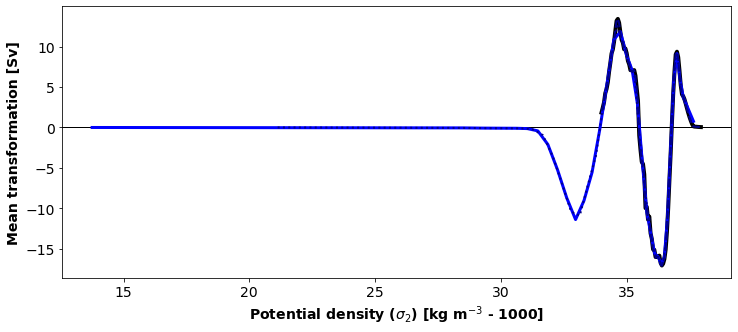

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
ax.axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
ax.plot(G_ctrl.coords[lstr], G_ctrl*1e-6, lw=4, c='k', ls='-')#,marker='o',ms=5)
ax.plot(Ga.coords[lstr], Ga*1e-6, lw=3, c='b', ls='-')#,marker='o',ms=5)
ax.plot(Gb.coords[lstr], Gb*1e-6, lw=2, c='darkblue', ls='--')#,marker='o',ms=5)
ax.plot(Gc.coords[lstr], Gc*1e-6, lw=2, c='darkblue', ls=':')#,marker='o',ms=5)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14,fontweight='bold')
ax.set_ylabel('Mean transformation [Sv]',fontsize=14,fontweight='bold')
#ax.set_xlim([34,38])
plt.show()

In [11]:
tst,tnd = '0121','0220' #'0281','0380'
G_mean = dsG.sel(time=slice(tst,tnd)).swmt.mean('time')
G_std = dsG.sel(time=slice(tst,tnd)).swmt.groupby('time.year').mean('time').std('year')

In [12]:
G_mean_sub = G_mean.sel(sigma2=slice(36,None))
sig_max = np.round(G_mean_sub[G_mean_sub.argmax()][lstr].values,2)
G_max = np.round(G_mean_sub[G_mean_sub.argmax()].values*1e-6,2)

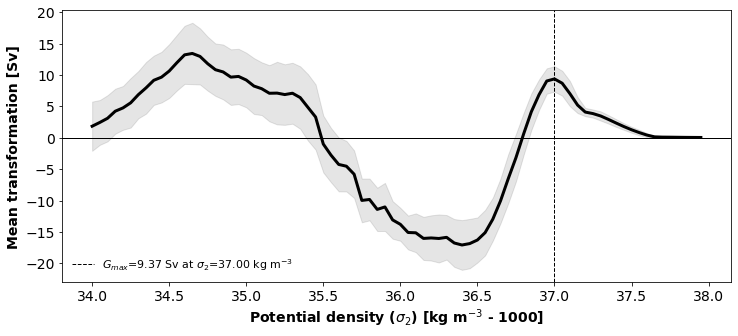

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
ax.axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
#val,dl = 37.025,0.05
if 'val' in locals():
    ax.fill([val-dl/2,val+dl/2,val+dl/2,val-dl/2],[-8,-8,13,13],hatch='/',fill=True,c='grey',alpha=0.1)
    
ax.fill_between(dsG.coords[lstr], (G_mean-G_std)*1e-6, (G_mean+G_std)*1e-6, alpha=0.1,
                edgecolor='k', facecolor='k')
ax.plot(dsG.coords[lstr], G_mean*1e-6, lw=3, c='k', ls='-')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14,fontweight='bold')
ax.set_ylabel('Mean transformation [Sv]',fontsize=14,fontweight='bold')
ax.axvline(x=sig_max, c = 'k', ls='--', lw=1, 
           label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
ax.legend(loc='lower left', ncol=1, fontsize=11,frameon=False)
plt.show()

## Decompose WMT

In [17]:
G = dd.G(lstr, bins=lbins, group_tend=False)
G['total'] = G.heat+G.salt

In [18]:
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
fname = head+'_so_%sto%s_southof%sS_%s_decomposed_%s_%s.nc'\
        %(str(ds_so.time.dt.year[0].values).rjust(4, '0'),
          str(ds_so.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, str(dl).replace('.','').ljust(3, '0'))
print('Saving to file:', fname)

with ProgressBar():
    G.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_antwaterstress_201_so_0001to0100_southof300S_swmt_decomposed_sigma2_005.nc
[########################################] | 100% Completed |  1min 33.2s


In [19]:
fname = 'ESM4_antwaterstress_151_so_0001to0100_southof300S_swmt_decomposed_sigma2_005.nc'

In [20]:
G = xr.open_dataset(outdir+fname)
G_mean = G.mean('time')
G_std = G.groupby('time.year').mean('time').std('year')

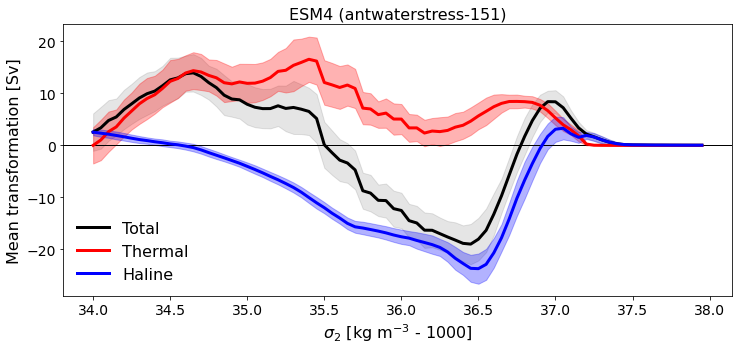

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.fill_between(G[lstr], (G_mean.total-G_std.total)*1e-6, (G_mean.total+G_std.total)*1e-6, 
                alpha=0.1, edgecolor='k', facecolor='k')
ax.plot(G[lstr], G_mean.total*1e-6, color='k', linestyle='-', lw=3, label='Total')#,marker='.')
ax.fill_between(G[lstr], (G_mean.heat-G_std.heat)*1e-6, (G_mean.heat+G_std.heat)*1e-6, 
                alpha=0.3, edgecolor='r', facecolor='r')
ax.plot(G[lstr], G_mean.heat*1e-6, color='r', linestyle='-', lw=3, label='Thermal')
ax.fill_between(G[lstr], (G_mean.salt-G_std.salt)*1e-6, (G_mean.salt+G_std.salt)*1e-6, 
                alpha=0.3, edgecolor='b', facecolor='b')
ax.plot(G[lstr], G_mean.salt*1e-6, color='b', linestyle='-', lw=3, label='Haline')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('$\sigma_%s$ [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=16)
ax.set_ylabel('Mean transformation [Sv]',fontsize=16)
ax.legend(frameon=False, fancybox=False, loc='lower left', ncol=1, fontsize=16)
ax.set_title('%s (%s)'%(mod,exp) if exp=='control' else '%s (%s-%s)'%(mod,exp,str(mem)),
             fontsize=16)
plt.show()

In [11]:
from plot import hovmoeller

In [23]:
G_ann = G.groupby('time.year').mean('time')*1e-6
G_anom = G_ann - G_ann.mean('year')

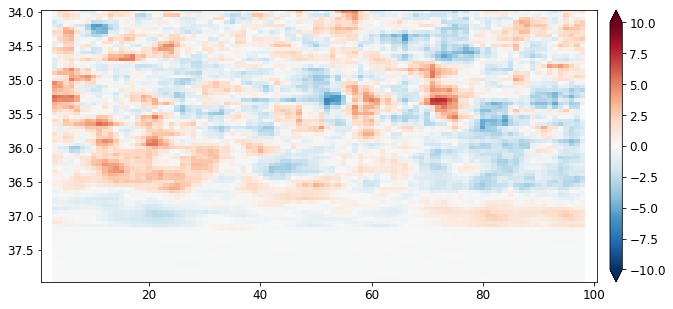

In [24]:
fig = hovmoeller(G_anom.heat.rolling(year=5,center=True).mean(), fsize=[12, 5], cmap='RdBu_r', yincrease=False, 
                 vrange=[-10,10])

In [25]:
G_ctrl = xr.open_dataset(outdir+'ESM4_control_so_0101to0270_southof300S_swmt_decomposed_sigma2_005.nc')
G_ctrl_mean = G_ctrl.sel(time=slice('0121','0220')).mean('time')*1e-6

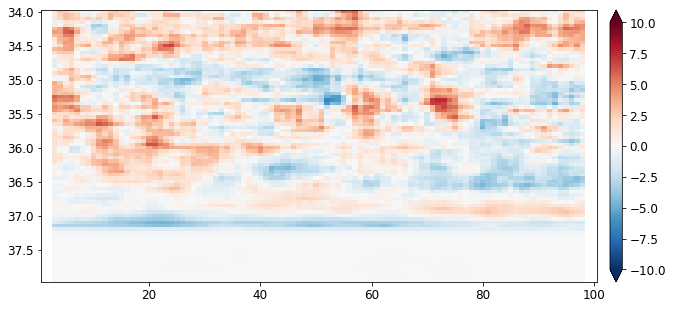

In [26]:
fig = hovmoeller((G_ann-G_ctrl_mean).heat.rolling(year=5,center=True).mean(), fsize=[12, 5], cmap='RdBu_r', 
                 yincrease=False, vrange=[-10,10])

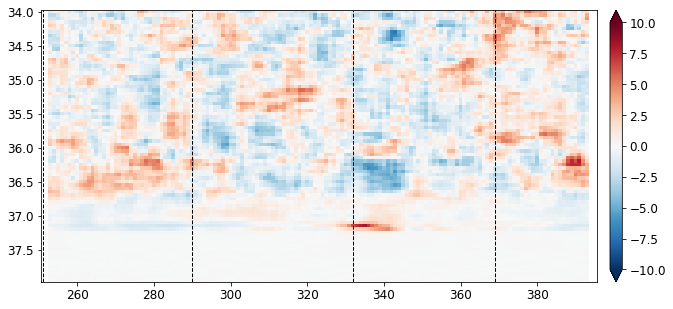

In [25]:
fig = hovmoeller(G_anom.heat.rolling(year=5,center=True).mean(), fsize=[12, 5], cmap='RdBu_r', yincrease=False, 
                 vrange=[-10,10], vline=[251,290,332,369])

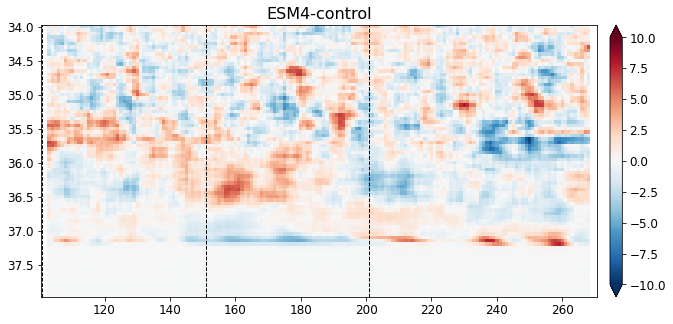

In [22]:
fig = hovmoeller(G_anom.heat.rolling(year=5,center=True).mean(), fsize=[12, 5], cmap='RdBu_r', yincrease=False, 
                 vrange=[-10,10],vline=[101, 151, 201],title='%s-%s'%(mod,exp))

## Surface density flux

In [21]:
import calendar
from plot import cartopy_map_so
from plot import map_transformation_rate_so

In [14]:
with ProgressBar():
    rho_flx_salt = dd.calc_Fl(lstr)[0]['salt'].squeeze().load()
    rho_flx_heat = dd.calc_Fl(lstr)[0]['heat'].squeeze().load()

[########################################] | 100% Completed |  9min 15.5s
[########################################] | 100% Completed |  6min 49.6s


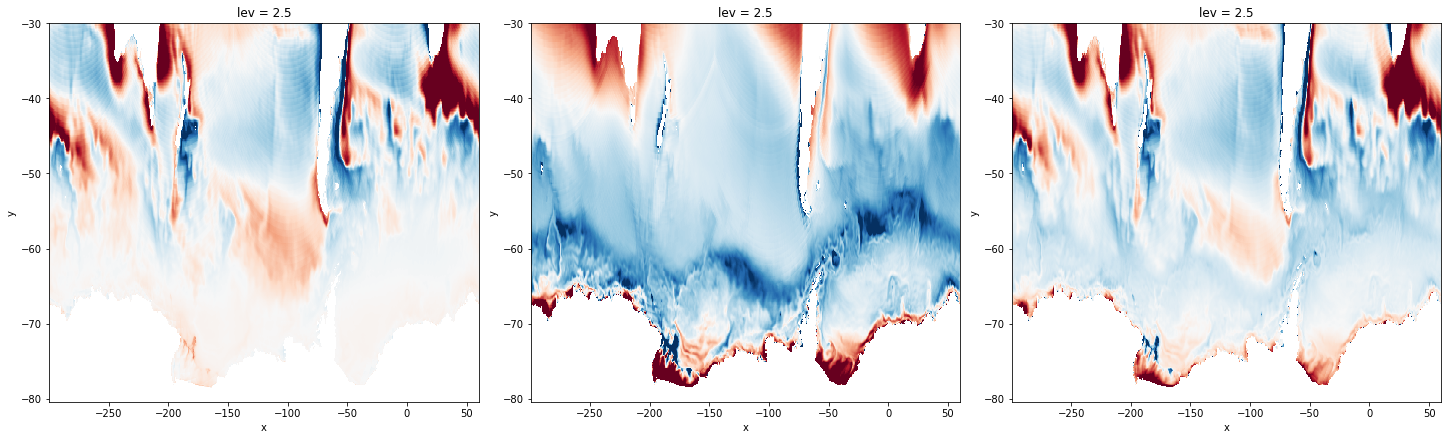

In [15]:
fig, axs = plt.subplots(ncols=3, constrained_layout=True, figsize=(20,6))
rho_flx_heat.sel(time=slice(yr_st,yr_ed)).mean('time').plot(robust=True,ax=axs[0],add_colorbar=False)
rho_flx_salt.sel(time=slice(yr_st,yr_ed)).mean('time').plot(robust=True,ax=axs[1],add_colorbar=False)
(rho_flx_heat+rho_flx_salt).sel(time=slice(yr_st,yr_ed)).mean('time').plot(robust=True,ax=axs[2],add_colorbar=False)

In [16]:
rho_flx = rho_flx_heat.reset_coords(drop=True).to_dataset(name='heat')
rho_flx['salt'] = rho_flx_salt.reset_coords(drop=True)
rho_flx['total'] = (rho_flx_heat+rho_flx_salt).reset_coords(drop=True)

In [17]:
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
fname = head+'_so_%sto%s_southof%sS_rho_flx.nc'\
        %(str(ds_so.time.dt.year[0].values).rjust(4, '0'),str(ds_so.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''))
print('Saving to file:', fname)
rho_flx.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_control_so_0251to0395_southof300S_rho_flx.nc


In [18]:
rho_flx

<xarray.Dataset>
Dimensions:  (x: 1440, y: 378, time: 1740)
Coordinates:
  * x        (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.28 59.53 59.78 60.03
  * y        (y) float64 -80.39 -80.31 -80.23 -80.15 ... -30.46 -30.24 -30.02
  * time     (time) object 0251-01-16 12:00:00 ... 0395-12-16 12:00:00
Data variables:
    heat     (time, y, x) float64 nan nan nan ... -3.928e-06 -4.177e-06
    salt     (time, y, x) float64 nan nan nan ... 4.173e-07 3.135e-07 2.029e-07
    total    (time, y, x) float64 nan nan nan ... -3.615e-06 -3.975e-06

In [17]:
#fname = 'ESM4_antwater_101_so_0101to0175_southof300S_rho_flx_sigma2.nc'
Fexp = xr.open_dataset(outdir+fname)
Fctr = xr.open_dataset(outdir+'ESM4_control_so_0101to0270_southof300S_rho_flx_sigma2.nc')

In [18]:
tctr = ['0281', '0380'] if mod=='CM4' else ['0121', '0220']

In [19]:
m = None # None, 9
if m:
    print('Seasonal mean in',calendar.month_abbr[m])
    ds_so['Fctr'] = Fctr.salt[Fctr.time.dt.month==m].sel(time=slice(tctr[0],tctr[1])).mean('time')
    ds_so['Fexp'] = Fexp.salt[Fexp.time.dt.month==m].sel(time=slice(yr_st,yr_ed)).mean('time')
    cbstr = 'Mean '+calendar.month_abbr[m]+' density flux'
else:
    print('Annul mean')
    ds_so['Fctr'] = Fctr.salt.sel(time=slice(tctr[0],tctr[1])).mean('time')
    ds_so['Fexp'] = Fexp.salt.sel(time=slice(yr_st,yr_ed)).mean('time')
    cbstr = 'Mean density flux'

Annul mean


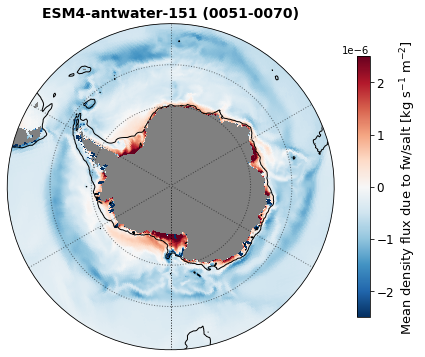

In [20]:
fig = cartopy_map_so(ds_so,'Fexp', lat=-50, cmap='RdBu_r', drawBath=True, vrange=[-2.5e-6,2.5e-6],
                     drawGrid=True, parallels=[-70,-60,-50], fsize=[8, 6],
                     title='%s-%s-%s (%s-%s)'%(mod,exp,str(mem),yr_st,yr_ed),
                     cb_label=cbstr+' due to fw/salt [kg s$^{-1}$ m$^{-2}$]')

In [21]:
ds_so['Fdiff'] = (ds_so.Fexp-ds_so.Fctr)

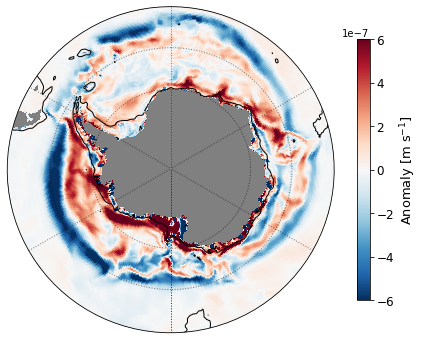

In [22]:
fig = cartopy_map_so(ds_so,'Fdiff', lat=-50, cmap='RdBu_r', drawBath=True,
                     vrange=[-6e-7,6e-7], drawGrid=True, parallels=[-70,-60,-50], fsize=[8, 6],
                     cb_label='Anomaly [m s$^{-1}$]')

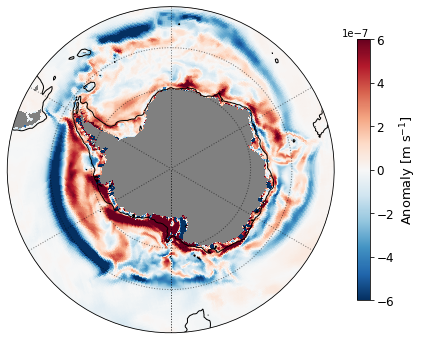

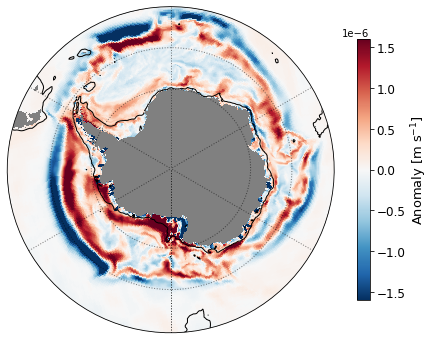

In [24]:
for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            ds = xr.open_zarr(file_path)
            
            if mod == 'CM4':
                subdir = 'CM4_piControl_C'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
            elif mod == 'ESM4':
                subdir = 'ESM4_piControl_D'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
        
            ds = preprocessing(ds, grid, decode_times=False, verbose=False)
            ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)
            ds_so['time_bnds'] = ds.time_bnds
            
            # Initialize 2D surface WMT class
            dd = swmt(ds_so)
            
            rho_flx_salt = dd.calc_Fl(lstr)[0]['salt'].squeeze()
            rho_flx_heat = dd.calc_Fl(lstr)[0]['heat'].squeeze()
            rho_flx = rho_flx_heat.reset_coords(drop=True).to_dataset(name='heat')
            rho_flx['salt'] = rho_flx_salt.reset_coords(drop=True)
            rho_flx['total'] = (rho_flx_heat+rho_flx_salt).reset_coords(drop=True)
            
            head = '%s_%s_%s'%(mod,exp,str(mem))
            fname = head+'_so_%sto%s_southof%sS_rho_flx.nc'\
                    %(str(ds_so.time.dt.year[0].values).rjust(4, '0'),
                      str(ds_so.time.dt.year[-1].values).rjust(4, '0'),
                      str(abs(north)).replace('.',''))
            print('Saving to file:', fname)
            with ProgressBar():
                rho_flx.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_antwater_251_so_0001to0100_southof300S_rho_flx.nc
[########################################] | 100% Completed |  6min 55.6s
Saving to file: CM4_antwater_290_so_0001to0070_southof300S_rho_flx.nc
[########################################] | 100% Completed |  4min 40.1s
Saving to file: CM4_antwater_332_so_0001to0070_southof300S_rho_flx.nc
[########################################] | 100% Completed |  4min 52.0s
Saving to file: CM4_stress_251_so_0001to0100_southof300S_rho_flx.nc
[########################################] | 100% Completed |  6min 42.5s
Saving to file: CM4_stress_290_so_0001to0070_southof300S_rho_flx.nc
[########################################] | 100% Completed |  4min 40.2s
Saving to file: CM4_stress_332_so_0001to0070_southof300S_rho_flx.nc
[########################################] | 100% Completed |  4min 46.9s
Saving to file: CM4_antwaterstress_251_so_0001to0100_southof300S_rho_flx.nc
[########################################] | 100% Completed |  6mi

## Spatial maps of transformation

In [35]:
val = 37.19
dl = 0.02
yr_st,yr_ed = '0281','0380'
print(yr_st,yr_ed)
#ti,tf='0281','0380' #CM4
#ti='0121',tf='0220' #ESM4

0281 0380


In [36]:
dsF = dd.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed,group_tend=False)
F_tot = dd.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed)

In [37]:
dsF['total'] = F_tot.reset_coords(drop=True)

dl_str = str(dl).replace('.','').ljust(3, '0')
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
fname = head+'_so_%sto%s_southof%sS_Fmap_decomposed_%s_%s_at%s.nc'\
                %(yr_st,yr_ed,str(abs(north)).replace('.',''), 
                  lstr, dl_str,('%.2f'%val).replace('.',''))
print('Saving to file:', fname)
#with ProgressBar():
#    dsF.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_control_so_0281to0380_southof300S_Fmap_decomposed_sigma2_002_at3719.nc


In [38]:
dsF = xr.open_dataset(outdir+fname)

In [19]:
with ProgressBar():
    sig = dd.get_density(lstr)[2].sum('lev_outer').sel(time=slice(yr_st,yr_ed)).where(ds_so['wet']==1).load()

[########################################] | 100% Completed | 51.6s


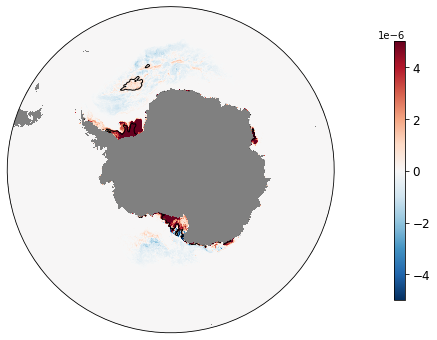

In [26]:
fig = map_transformation_rate_so(dsF.salt, ds_so, sig, val, month=[10], fsize=[8,6],
                                 draw_Mean=False, lat=-50, vrange=[-5e-6,5e-6])

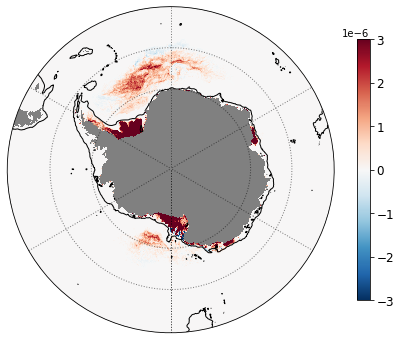

In [39]:
ds_so['F'] = dsF.total
fig = cartopy_map_so(ds_so,'F', lat=-50, cmap='RdBu_r', drawBath=True,
                     vrange=[-3e-6,3e-6], drawGrid=True, parallels=[-70,-60,-50], fsize=[8, 6])

In [ ]:
fig.savefig('/home/jtesdal/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)

In [18]:
for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            ds = xr.open_zarr(file_path)
            
            if mod == 'CM4':
                subdir = 'CM4_piControl_C'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
            elif mod == 'ESM4':
                subdir = 'ESM4_piControl_D'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
                
            ds = preprocessing(ds, grid, decode_times=False, verbose=False)
            
            # Isolate Southern Ocean
            ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)
            ds_so['time_bnds'] = ds.time_bnds
            
            # Initialize 2D surface WMT class
            dd = swmt(ds_so)
                
            if mod=='CM4':
                if exp=='control':
                    yr_st,yr_ed = '0281','0380'
                else:
                    yr_st,yr_ed = '0051','0070'
            elif mod=='ESM4':
                if exp=='control':
                    yr_st,yr_ed = '0121','0220'
                elif mem=='101':
                    yr_st,yr_ed = '0151','0170'
                else:
                    yr_st,yr_ed = '0051','0070'
            #print(yr_st,yr_ed)
            dsF = dd.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed,group_tend=False)
            F_tot = dd.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed)
            dsF['total'] = F_tot.reset_coords(drop=True)
            head = '%s_%s_%s'%(mod,exp,str(mem))
            fname = head+'_so_%sto%s_southof%sS_Fmap_decomposed_%s_%s_at%s.nc'\
                        %(yr_st,yr_ed,str(abs(north)).replace('.',''), 
                          lstr, dl_str,('%.2f'%val).replace('.',''))
            print('Saving to file:', fname)
            with ProgressBar():
                dsF.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_antwater_251_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  5.6s
Saving to file: CM4_antwater_290_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  5.5s
Saving to file: CM4_antwater_332_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  5.5s
Saving to file: CM4_stress_251_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  6.0s
Saving to file: CM4_stress_290_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  5.4s
Saving to file: CM4_stress_332_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed 

In [32]:
Fctr = xr.open_dataset(outdir+'ESM4_control_so_0101to0270_southof300S_Fmap_sigma2_002_at3695.nc')
Fexp = xr.open_dataset(outdir+'ESM4_antwater_101_so_0101to0175_southof300S_Fmap_sigma2_002_at3695.nc')

In [34]:
ds_so['Fdiff'] = (Fexp.transformation-Fctr.transformation)

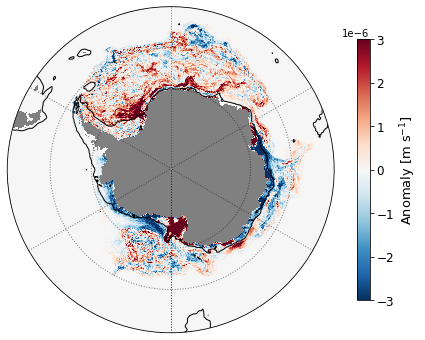

In [35]:
fig = cartopy_map_so(ds_so,'Fdiff', lat=-50, cmap='RdBu_r', drawBath=True,
                     vrange=[-3e-6,3e-6], drawGrid=True, parallels=[-70,-60,-50], fsize=[8, 6],
                     cb_label='Anomaly [m s$^{-1}$]')

## Surface-forced streamfunction

In [12]:
lstr = 'sigma2'
#dl,sigi,sigf = 0.02, 35.41, 37.89
dl,sigi,sigf = 0.05, 34.0 , 38.0
#dl,sigi,sigf = 0.125, 34.0625 , 36.8125
lbins = lbin_define(sigi,sigf,dl)
#lbins = rho2_i-1000

In [13]:
north = -30.0
#lats = grid.sel(yq=slice(None,grid.sel(yq=[north], method='nearest').squeeze().yq.values)).yq.values
lats = np.linspace(-80,-30,51)
Gs = []

In [14]:
for latn in lats:
    if latn<grid.yh[0]:
        continue
    #print(latn)
    ds_so = ds.drop_dims('nv').where(ds.lat<latn,drop=True)
    ds_so['time_bnds'] = ds.time_bnds
    
    dd = swmt(ds_so)
    G = dd.G(lstr, bins=lbins)
    G['y'] = latn
    Gs.append(G)

In [15]:
G_srf = xr.concat(Gs, dim='y').transpose('time','sigma2','y')
#G_srf.yq.attrs = grid.yq.attrs

In [16]:
with ProgressBar():
    Gstmf = G_srf.isel(time=slice(-12,None)).mean('time').load()

[########################################] | 100% Completed | 23.0s


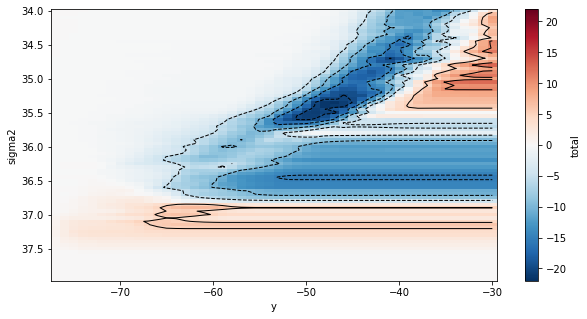

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
(Gstmf*1e-6).plot(ax=ax, yincrease=False,cmap='RdBu_r',vmin=-22,vmax=22)
(Gstmf*1e-6).plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-25,0,5),np.arange(5,30,5)]), 
                          colors='k', linewidths=1)
plt.show()

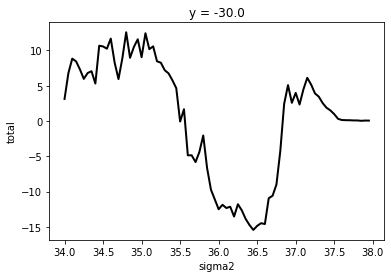

In [18]:
(Gstmf*1e-6).sel(y=-30, method='nearest').squeeze().plot(c='k',lw=2)

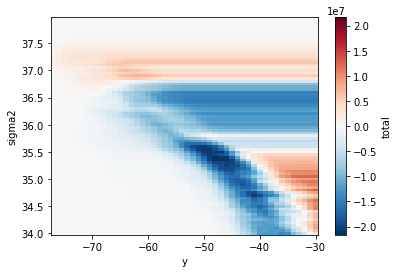

In [19]:
Gstmf.plot()

In [20]:
dsG = G_srf.reset_coords(drop=True).to_dataset(name='swmt')

In [21]:
dsG = dsG.sel(time=slice('0098',None))

In [22]:
dsG

,Array,Chunk
Bytes,1.05 MiB,640 B
Shape,"(36, 80, 48)","(1, 80, 1)"
Count,7035767 Tasks,1728 Chunks
Type,float64,numpy.ndarray


In [23]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))

for yr in np.unique(dsG.time.dt.year):
    
    fname = head+'_so_%sto%s_southof%sS_%s_streamfunction_%s_%s_yr%s.nc'\
                %(str(ds.time.dt.year[0].values).rjust(4, '0'),
                  str(ds.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, lstr, dl_str, str(yr).rjust(4, '0'))
    
    print('Saving to file:', fname)
    with ProgressBar():
        dsG.sel(time=str(yr).rjust(4, '0')).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0098.nc
[########################################] | 100% Completed | 22.0s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0099.nc
[########################################] | 100% Completed | 23.1s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0100.nc
[########################################] | 100% Completed | 21.7s


In [24]:
fnames = head+'_so_%sto%s_southof%sS_%s_streamfunction_%s_%s_*.nc'%(str(ds.time.dt.year[0].values).rjust(4, '0'),
                                                                    str(ds.time.dt.year[-1].values).rjust(4, '0'),
                                                                    str(abs(north)).replace('.',''), var, 
                                                                    lstr, dl_str)
dsG = xr.open_mfdataset(outdir+fnames)

In [25]:
dsG

<xarray.Dataset>
Dimensions:  (time: 1200, sigma2: 80, y: 51)
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0100-12-16 12:00:00
  * sigma2   (sigma2) float64 34.0 34.05 34.1 34.15 ... 37.8 37.85 37.9 37.95
  * y        (y) float64 -80.0 -79.0 -78.0 -77.0 ... -33.0 -32.0 -31.0 -30.0
Data variables:
    swmt     (time, sigma2, y) float64 dask.array<chunksize=(12, 80, 51), meta=np.ndarray>

In [19]:
fname = head+'_so_%sto%s_southof%sS_%s_streamfunction_%s_%s.nc'%(str(dsG.time.dt.year[0].values).rjust(4, '0'),
                                                                 str(dsG.time.dt.year[-1].values).rjust(4, '0'),
                                                                 str(abs(north)).replace('.',''), var, 
                                                                 lstr, dl_str)
print('Saving to file:', fname)
with ProgressBar():
    dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_control_so_0101to0270_southof300S_swmt_streamfunction_sigma2_005.nc
[########################################] | 100% Completed |  0.3s


In [20]:
dsG = xr.open_dataset(outdir+fname)

In [22]:
Gstmf = dsG.sel(time=slice(yr_st,yr_ed)).swmt.mean('time')*1e-6

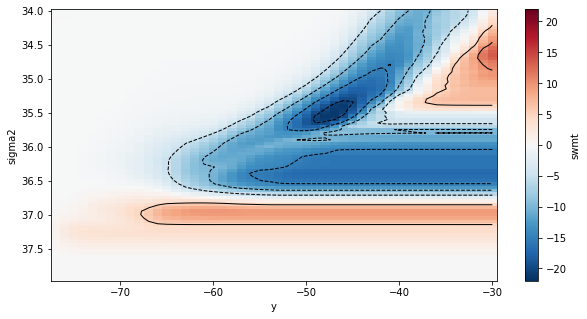

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
Gstmf.plot(ax=ax, yincrease=False,cmap='RdBu_r',vmin=-22,vmax=22)
Gstmf.plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-25,0,5),np.arange(5,30,5)]), 
                   colors='k', linewidths=1)
plt.show()

In [14]:
lstr

'sigma2'

In [ ]:
north = -30.0
#lats = grid.sel(yq=slice(None,grid.sel(yq=[north], method='nearest').squeeze().yq.values)).yq.values
lats = np.linspace(-80,-30,51)

var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')

for mod in ['CM4', 'ESM4']:
    if mod=='CM4':
        continue
    for exp in ['antwater', 'stress', 'antwaterstress']:
        if exp == 'antwaterstress':
            continue
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            print('Loading '+file_path)
            ds = xr.open_zarr(file_path)
            
            if mod == 'CM4':
                subdir = 'CM4_piControl_C'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
            elif mod == 'ESM4':
                subdir = 'ESM4_piControl_D'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                
            ds = preprocessing(ds, grid, decode_times=False, verbose=False)
            
            print('Calculate streamfunction')
            Gs = []
            for latn in lats:
                if latn<grid.yh[0]:
                    continue
                    
                ds_so = ds.drop_dims('nv').where(ds.lat<latn,drop=True)
                ds_so['time_bnds'] = ds.time_bnds
                
                dd = swmt(ds_so)
                G = dd.G(lstr, bins=lbins)
                G['y'] = latn
                Gs.append(G)
                
            G_srf = xr.concat(Gs, dim='y').transpose('time','sigma2','y')
            print(G_srf)
            
            dsG = G_srf.reset_coords(drop=True).to_dataset(name='swmt')
            print(str(dsG.time.values[0])[:10],'to',str(dsG.time.values[-1])[:10])
            head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
            for yr in np.unique(dsG.time.dt.year):
                fname = head+'_so_%sto%s_southof%sS_%s_streamfunction_%s_%s_yr%s.nc'\
                                %(str(ds.time.dt.year[0].values).rjust(4, '0'),
                                  str(ds.time.dt.year[-1].values).rjust(4, '0'),
                                  str(abs(north)).replace('.',''), var, lstr, dl_str, str(yr).rjust(4, '0'))
                print('Saving to file:', fname)
                with ProgressBar():
                    dsG.sel(time=str(yr).rjust(4, '0')).to_netcdf(outdir+fname, format='NETCDF4')

Loading /scratch/gpfs/jt7058/GFDL/fafmip/zarr/ESM4/antwater/101/monthly
Calculate streamfunction
<xarray.DataArray 'total' (time: 900, sigma2: 80, y: 48)>
dask.array<transpose, shape=(900, 80, 48), dtype=float64, chunksize=(1, 80, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0101-01-16 12:00:00 ... 0175-12-16 12:00:00
  * sigma2   (sigma2) float64 34.0 34.05 34.1 34.15 ... 37.8 37.85 37.9 37.95
  * y        (y) float64 -77.0 -76.0 -75.0 -74.0 ... -33.0 -32.0 -31.0 -30.0
0101-01-16 to 0175-12-16
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0101.nc
[########################################] | 100% Completed | 46.0s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0102.nc
[########################################] | 100% Completed | 47.4s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0103.nc
[####################################

[########################################] | 100% Completed | 23.8s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0147.nc
[########################################] | 100% Completed | 23.5s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0148.nc
[########################################] | 100% Completed | 24.3s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0149.nc
[########################################] | 100% Completed | 23.1s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0150.nc
[########################################] | 100% Completed | 23.0s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_005_yr0151.nc
[########################################] | 100% Completed | 23.5s
Saving to file: ESM4_antwater_101_so_0101to0175_southof300S_swmt_streamfunction_sigma2_

[########################################] | 100% Completed | 23.0s
Saving to file: ESM4_antwater_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0066.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_antwater_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0067.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_antwater_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0068.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_antwater_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0069.nc
[########################################] | 100% Completed | 23.3s
Saving to file: ESM4_antwater_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0070.nc
[########################################] | 100% Completed | 23.4s
Saving to file: ESM4_antwater_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_

[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_antwater_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0060.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_antwater_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0061.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_antwater_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0062.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_antwater_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0063.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_antwater_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0064.nc
[########################################] | 100% Completed | 23.3s
Saving to file: ESM4_antwater_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_

[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_stress_101_so_0101to0185_southof300S_swmt_streamfunction_sigma2_005_yr0106.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_101_so_0101to0185_southof300S_swmt_streamfunction_sigma2_005_yr0107.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_stress_101_so_0101to0185_southof300S_swmt_streamfunction_sigma2_005_yr0108.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_101_so_0101to0185_southof300S_swmt_streamfunction_sigma2_005_yr0109.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_101_so_0101to0185_southof300S_swmt_streamfunction_sigma2_005_yr0110.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_101_so_0101to0185_southof300S_swmt_streamfunction_sigma2_005_yr0111.n

[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0016.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0017.nc
[########################################] | 100% Completed | 22.9s
Saving to file: ESM4_stress_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0018.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0019.nc
[########################################] | 100% Completed | 23.3s
Saving to file: ESM4_stress_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0020.nc
[########################################] | 100% Completed | 23.3s
Saving to file: ESM4_stress_151_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0021.n

[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0011.nc
[########################################] | 100% Completed | 22.9s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0012.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0013.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0014.nc
[########################################] | 100% Completed | 22.7s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0015.nc
[########################################] | 100% Completed | 22.8s
Saving to file: ESM4_stress_201_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_yr0016.n

In [27]:
for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            print('Loading '+file_path)
            ds = xr.open_zarr(file_path)
            
            head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
            fnames = head+'_so_%sto%s_southof%sS_%s_streamfunction_%s_%s_*.nc'\
                %(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, lstr, dl_str)
            print('Loading files:', fnames)
            dsG = xr.open_mfdataset(outdir+fnames)
            
            fname = head+'_so_%sto%s_southof%sS_%s_streamfunction_%s_%s.nc'\
                %(str(dsG.time.dt.year[0].values).rjust(4, '0'),str(dsG.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, lstr, dl_str)
            print('Saving to file:', fname)
            with ProgressBar():
                dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Loading /scratch/gpfs/jt7058/GFDL/fafmip/zarr/CM4/antwater/251/monthly
Loading files: CM4_antwater_251_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005_*.nc
Saving to file: CM4_antwater_251_so_0001to0100_southof300S_swmt_streamfunction_sigma2_005.nc
[########################################] | 100% Completed |  0.1s
Loading /scratch/gpfs/jt7058/GFDL/fafmip/zarr/CM4/antwater/290/monthly
Loading files: CM4_antwater_290_so_0001to0070_southof300S_swmt_streamfunction_sigma2_005_*.nc
Saving to file: CM4_antwater_290_so_0001to0070_southof300S_swmt_streamfunction_sigma2_005.nc
[########################################] | 100% Completed |  0.1s
Loading /scratch/gpfs/jt7058/GFDL/fafmip/zarr/CM4/antwater/332/monthly
Loading files: CM4_antwater_332_so_0001to0070_southof300S_swmt_streamfunction_sigma2_005_*.nc
Saving to file: CM4_antwater_332_so_0001to0070_southof300S_swmt_streamfunction_sigma2_005.nc
[########################################] | 100% Completed |  0.1s
Loading /scratch/gpfs/

In [28]:
dsG = xr.open_dataset(outdir+fname)

In [29]:
dsG

<xarray.Dataset>
Dimensions:  (time: 1200, sigma2: 80, y: 48)
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0100-12-16 12:00:00
  * sigma2   (sigma2) float64 34.0 34.05 34.1 34.15 ... 37.8 37.85 37.9 37.95
  * y        (y) float64 -77.0 -76.0 -75.0 -74.0 ... -33.0 -32.0 -31.0 -30.0
Data variables:
    swmt     (time, sigma2, y) float64 ...

In [30]:
if mod=='CM4':
    if exp=='control':
        yr_st,yr_ed = '0281','0380'
    else:
        yr_st,yr_ed = '0051','0070'
elif mod=='ESM4':
    if exp=='control':
        yr_st,yr_ed = '0121','0220'
    elif mem==101:
        yr_st,yr_ed = '0151','0170'
    else:
        yr_st,yr_ed = '0051','0070'

In [31]:
Gstmf = dsG.sel(time=slice(yr_st,yr_ed)).swmt.mean('time')*1e-6

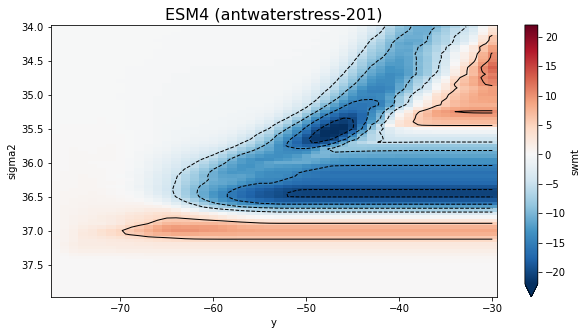

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
Gstmf.plot(ax=ax, yincrease=False,cmap='RdBu_r',vmin=-22,vmax=22)
Gstmf.plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-25,0,5),np.arange(5,30,5)]), 
                   colors='k', linewidths=1)
ax.set_title('%s (%s)'%(mod,exp) if exp=='control' else '%s (%s-%s)'%(mod,exp,str(mem)),fontsize=16)
plt.show()